In [2]:
import pandas as pd
import seaborn as sns
import gc
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import statsmodels.api as sm
import scipy
import plotly.express as px
from scipy.fft import fft
from scipy.signal import lombscargle
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pprint import pprint
from scipy import stats
import random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import ttest_ind
from matplotlib.pyplot import tick_params
from sklearn.impute import SimpleImputer

pl.disable_string_cache()
pl.Config.set_streaming_chunk_size(10000)

polars.config.Config

In [3]:
# Loading the dataset (mmt.parquet)
columns = [ "Epoch", "range_km", "Mag", "sat_j2000", "obs_j2000", "az_rad", "el_rad", 'phase_angle_rad', 'Channel','Filter', "Track", "epsecs", "Satellite"]

N = 300000000
lf = pl.scan_parquet("mmt.parquet").limit(n=N).select(columns)
print(lf.collect_schema())

Schema({'Epoch': Datetime(time_unit='ms', time_zone='UTC'), 'range_km': Float32, 'Mag': Float32, 'sat_j2000': Array(Float32, shape=(3,)), 'obs_j2000': Array(Float32, shape=(3,)), 'az_rad': Float32, 'el_rad': Float32, 'phase_angle_rad': Float32, 'Channel': UInt8, 'Filter': String, 'Track': UInt32, 'epsecs': Float32, 'Satellite': UInt32})


In [4]:
# Sampling the dataset
sample_rate = 0.001 
lf = lf.with_row_index("row_num")

sampled_lf = lf.filter(pl.col("row_num") % int(1/sample_rate) == 0)
sampled_df = sampled_lf.collect()

print(sampled_df.shape)
sampled_df.describe()

(278634, 14)


statistic,row_num,Epoch,range_km,Mag,sat_j2000,obs_j2000,az_rad,el_rad,phase_angle_rad,Channel,Filter,Track,epsecs,Satellite
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64
"""count""",278634.0,"""278634""",278634.0,278634.0,278634.0,278634.0,278634.0,278634.0,278634.0,278634.0,"""278634""",278634.0,278634.0,278634.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0
"""mean""",1.393165e8,"""2020-04-06 13:16:39.024000+00:…",7647.14502,7.561785,null,null,3.169698,0.95632,1.087456,4.950867,null,1.7599e7,384.558472,32634.517848
"""std""",8.0435e7,null,9533.287109,1.464272,null,null,1.590384,0.246596,0.458914,2.490713,null,6.6445e6,1107.786011,14580.085722
"""min""",0.0,"""2014-06-04 19:53:59.729000+00:…",338.891571,-1.61867,null,null,0.000065,0.001196,0.007399,1.0,"""B""",10.0,0.0,5.0
"""25%""",6.9658e7,"""2018-01-03 02:49:26.700000+00:…",1219.821655,6.62005,null,null,2.18176,0.779853,0.729466,3.0,null,1.2902448e7,24.502001,25615.0
"""50%""",1.39317e8,"""2020-05-20 00:29:16.897000+00:…",2258.660156,7.79977,null,null,3.130396,0.955194,1.10297,5.0,null,1.7543124e7,67.405006,36869.0
"""75%""",2.08975e8,"""2022-11-13 02:41:49.598000+00:…",11769.416016,8.69599,null,null,4.248258,1.126229,1.439835,7.0,null,2.1883283e7,298.0,43583.0
"""max""",2.78633e8,"""2024-12-01 03:31:21.597000+00:…",44997.839844,11.2061,null,null,6.283181,1.570041,2.841413,9.0,"""V""",3.0228913e7,38355.511719,61615.0


# Data Cleaning
### Checking for missing values

In [5]:
sampled_df = sampled_df.drop_nans()
sampled_df = sampled_df.drop_nulls()
sampled_df.null_count()

row_num,Epoch,range_km,Mag,sat_j2000,obs_j2000,az_rad,el_rad,phase_angle_rad,Channel,Filter,Track,epsecs,Satellite
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# Checking for duplicated rows
print(sampled_df.shape[0])
print(sampled_df.unique())

278634
shape: (278_634, 14)
┌───────────┬─────────────┬─────────────┬─────────┬───┬────────┬──────────┬────────────┬───────────┐
│ row_num   ┆ Epoch       ┆ range_km    ┆ Mag     ┆ … ┆ Filter ┆ Track    ┆ epsecs     ┆ Satellite │
│ ---       ┆ ---         ┆ ---         ┆ ---     ┆   ┆ ---    ┆ ---      ┆ ---        ┆ ---       │
│ u32       ┆ datetime[ms ┆ f32         ┆ f32     ┆   ┆ str    ┆ u32      ┆ f32        ┆ u32       │
│           ┆ , UTC]      ┆             ┆         ┆   ┆        ┆          ┆            ┆           │
╞═══════════╪═════════════╪═════════════╪═════════╪═══╪════════╪══════════╪════════════╪═══════════╡
│ 92909000  ┆ 2020-09-19  ┆ 9214.52832  ┆ 7.3973  ┆ … ┆ C      ┆ 18288090 ┆ 1235.60107 ┆ 20559     │
│           ┆ 23:54:47.69 ┆             ┆         ┆   ┆        ┆          ┆ 4          ┆           │
│           ┆ 5 UTC       ┆             ┆         ┆   ┆        ┆          ┆            ┆           │
│ 29846000  ┆ 2023-01-12  ┆ 11504.33691 ┆ 9.5365  ┆ … ┆ C      

### Checking for Outliers

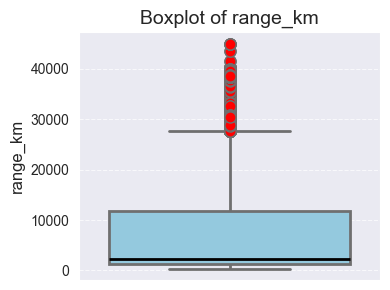

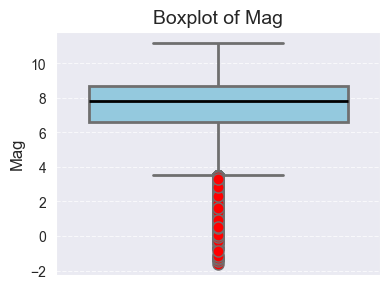

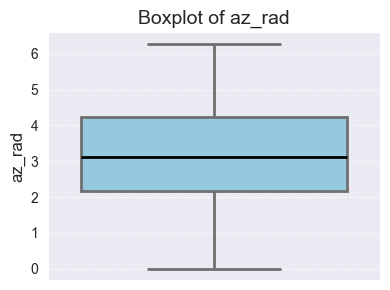

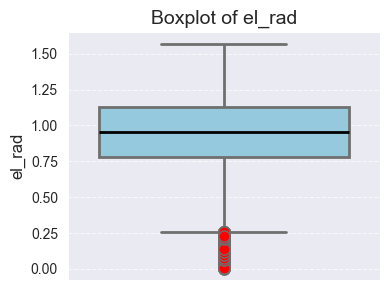

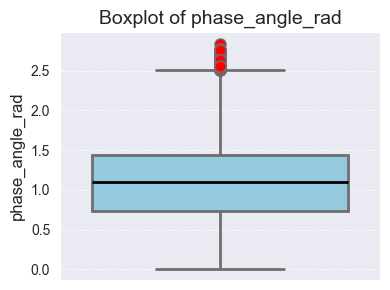

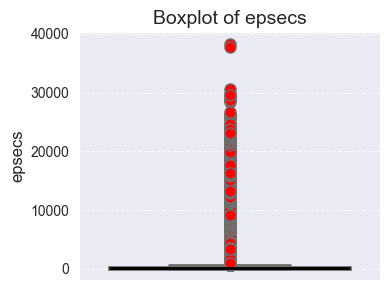

shape: (54_371, 15)
┌───────────┬────────────┬────────────┬─────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ row_num   ┆ Epoch      ┆ range_km   ┆ Mag     ┆ … ┆ Track    ┆ epsecs    ┆ Satellite ┆ outlier_c │
│ ---       ┆ ---        ┆ ---        ┆ ---     ┆   ┆ ---      ┆ ---       ┆ ---       ┆ olumn     │
│ u32       ┆ datetime[m ┆ f32        ┆ f32     ┆   ┆ u32      ┆ f32       ┆ u32       ┆ ---       │
│           ┆ s, UTC]    ┆            ┆         ┆   ┆          ┆           ┆           ┆ str       │
╞═══════════╪════════════╪════════════╪═════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 932000    ┆ 2024-11-06 ┆ 37627.9414 ┆ 9.20845 ┆ … ┆ 30011838 ┆ 10.700001 ┆ 22653     ┆ range_km  │
│           ┆ 01:14:59.4 ┆ 06         ┆         ┆   ┆          ┆           ┆           ┆           │
│           ┆ 02 UTC     ┆            ┆         ┆   ┆          ┆           ┆           ┆           │
│ 2097000   ┆ 2015-09-17 ┆ 37239.7890 ┆ 9.13721 ┆ … ┆ 8782194  ┆ 270.70

In [7]:
# Handling only numerical columns
outliers_data = []
for col in sampled_df.columns[1:]:
    try:
        if sampled_df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]:
            q1 = sampled_df.get_column(col).quantile(0.25)
            q3 = sampled_df.get_column(col).quantile(0.75)

            if q1 is not None and q3 is not None:
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                outliers_col = sampled_df.filter(
                    (sampled_df.get_column(col) < lower_bound) | (sampled_df.get_column(col) > upper_bound)
                )
                outliers_col = outliers_col.with_columns(pl.lit(col).alias("outlier_column"))
                outliers_data.append(outliers_col)

                plt.figure(figsize=(4, 3))
                sns.boxplot(
                    y=sampled_df.get_column(col),
                    color="skyblue",
                    flierprops={'marker': 'o', 'markersize': 8, 'markerfacecolor': 'red'},
                    boxprops={'linewidth': 2},
                    whiskerprops={'linewidth': 2},
                    capprops={'linewidth': 2},
                    medianprops={'color': 'black', 'linewidth': 2}
                )
                plt.title(f'Boxplot of {col}', fontsize=14)
                plt.ylabel(col, fontsize=12)
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
    except Exception as e:
        print(f"Error processing column {col}: {e}")

if outliers_data:
    outliers = pl.concat(outliers_data)
else:
    outliers = pl.DataFrame()

print(outliers)

## Handeling Outliers
These outliers are unpredictable and do not follow a pattern, so we can't remove them. There are not any outliers per satellite only satellites that can be outliers. 

Removing satellites will require prior knowledge of the data, it is statistically possible to remove these outliers by grouping the data by satellite and removing those satellites which have consistent observations outside the inter quantile range.



### Heatmap of Correlation

                 range_km       Mag    az_rad    el_rad  phase_angle_rad  \
range_km         1.000000  0.427959 -0.017078 -0.281366        -0.585498   
Mag              0.427959  1.000000 -0.021081 -0.098761        -0.238693   
az_rad          -0.017078 -0.021081  1.000000 -0.049950         0.020038   
el_rad          -0.281366 -0.098761 -0.049950  1.000000         0.109346   
phase_angle_rad -0.585498 -0.238693  0.020038  0.109346         1.000000   
epsecs           0.379499  0.208358 -0.050469 -0.037478        -0.220166   

                   epsecs  
range_km         0.379499  
Mag              0.208358  
az_rad          -0.050469  
el_rad          -0.037478  
phase_angle_rad -0.220166  
epsecs           1.000000  


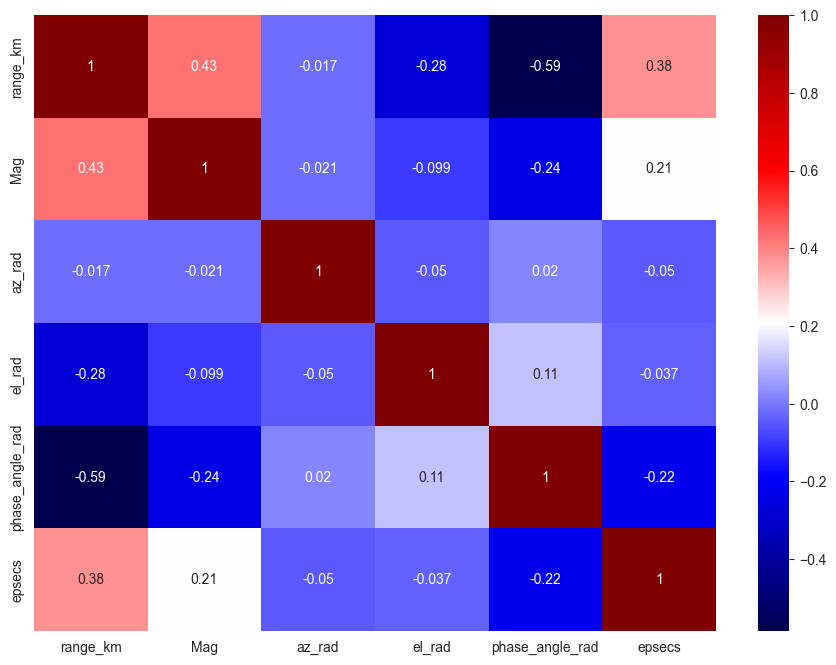

In [8]:
try:
    sampled_df_w_epoch = sampled_df
    sampled_df = sampled_df.drop("Epoch")
except Exception as e:
    print(f"Error dropping column 'Epoch': {e}")

try:
    numerical_columns = [col for col in sampled_df.columns if sampled_df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]]
    numerical_df = sampled_df.select(numerical_columns)
    corr_matrix = numerical_df.to_pandas().corr()
    print(corr_matrix)
except Exception as e:
    print(f"Error calculating correlation matrix: {e}")

try:
    plt.figure(figsize=(11, 8))
    sns.heatmap(corr_matrix, cmap="seismic", annot=True, xticklabels=numerical_df.columns, yticklabels=numerical_df.columns)
    plt.show()
except Exception as e:
    print(f"Error creating heatmap: {e}")

## Finding Correlation between brightness and range.

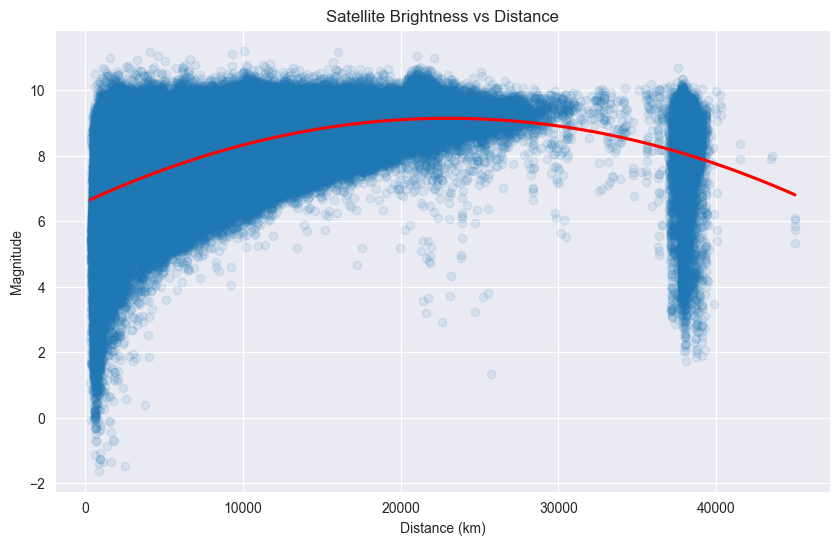

Correlation coefficient: shape: (2, 2)
┌──────────┬──────────┐
│ range_km ┆ Mag      │
│ ---      ┆ ---      │
│ f64      ┆ f64      │
╞══════════╪══════════╡
│ 1.0      ┆ 0.427959 │
│ 0.427959 ┆ 1.0      │
└──────────┴──────────┘
R-squared: 0.18314859561300884


In [9]:
brightness_range_df = sampled_df[["range_km", "Mag"]]

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(data=brightness_range_df, x="range_km", y="Mag", order=2, scatter_kws={'alpha':0.1}, line_kws=dict(color='red'))
plt.title("Satellite Brightness vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Magnitude")
plt.show()

# Calculate correlation
correlation = brightness_range_df.corr()
print(f"Correlation coefficient: {correlation}")

# Fit regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(brightness_range_df["range_km"], brightness_range_df["Mag"])
print(f"R-squared: {r_value**2}")


This shows that the magnitude (negative logarithm of mag) decreases according to the range_km


## Finding the Variaton of Brightness per Satellite

In [10]:
satellites = sampled_df["Satellite"].unique()
print(len(satellites))
satellite_id = satellites[1]

10829


In [11]:
# Each satellite has different tracks, it becomes easier if we just make a dictionary of the tracks for each satellite.

satellite_tracks = sampled_df.group_by("Satellite").agg(pl.col("Track").unique())
satellite_tracks_dict = {row["Satellite"]: row["Track"] for row in satellite_tracks.to_dicts()} 

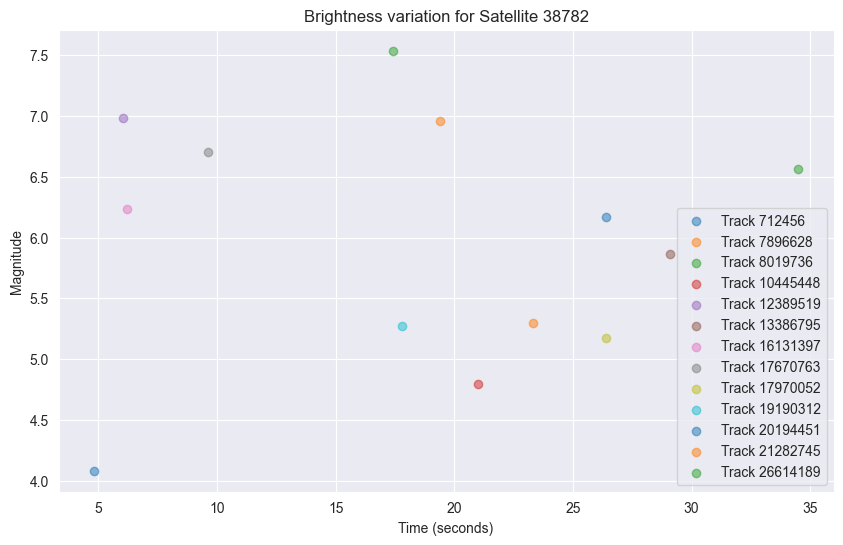

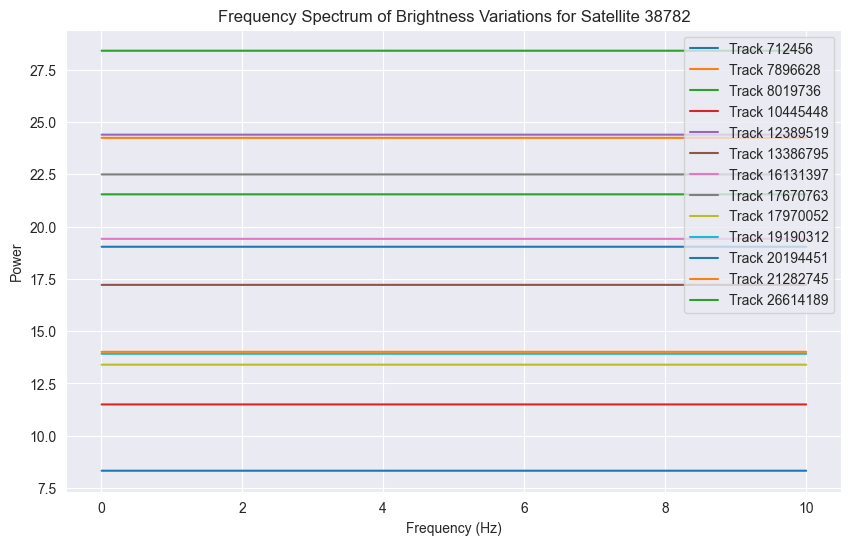

In [12]:
# Select a specific satellite ID
satellite_id = 38782

try:
    satellite_df = sampled_df.filter(pl.col("Satellite") == satellite_id)

    plt.figure(figsize=(10, 6))
    for track_id in satellite_tracks_dict[satellite_id]:
        track_data = satellite_df.filter(pl.col("Track") == track_id)
        plt.scatter(track_data["epsecs"], track_data["Mag"], alpha=0.5, label=f'Track {track_id}')
    plt.title(f"Brightness variation for Satellite {satellite_id}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.show()

    
    # To check the frequency spectrum of the brightness variations, we can use the Lomb-Scargle method.
    plt.figure(figsize=(10, 6))
    for track_id in satellite_tracks_dict[satellite_id]:
        track_data = satellite_df.filter(pl.col("Track") == track_id)
        time = track_data["epsecs"]
        magnitude = track_data["Mag"]
        frequencies = np.linspace(0.01, 10, 10000)
        power = lombscargle(time, magnitude, frequencies)
        plt.plot(frequencies, power, label=f'Track {track_id}')
    plt.title(f"Frequency Spectrum of Brightness Variations for Satellite {satellite_id}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error processing satellite {satellite_id}: {e}")

The Lomb-Scarle method is used to find the frequency spectrum of the brightness variations for each track of the satellite. The frequency spectrum shows the power of the signal at different frequencies. The power is the square of the amplitude of the signal at that frequency. The frequency spectrum can be used to identify the dominant frequencies in the signal.

In [13]:
## Now lets incorporate the range_km per sattlelite
mag_rangekm_sampled_df = sampled_df[["Satellite", "Mag", "range_km"]]
mag_rangekm_sampled_df.group_by("Satellite").agg(pl.col("Mag").mean().alias("Mean_Mag"), pl.col("range_km").mean().alias("Mean_Range")).sort("Mean_Mag")


Satellite,Mean_Mag,Mean_Range
u32,f32,f32
46390,-0.063702,364.999725
39000,0.201413,565.657654
43641,0.737802,732.092041
20442,0.841873,936.300964
46265,0.864047,782.401123
…,…,…
23687,10.1712,15285.430664
10653,10.2318,1643.367554
23641,10.3012,5854.407227


### Finding Variation between Brightness and Phase Angle

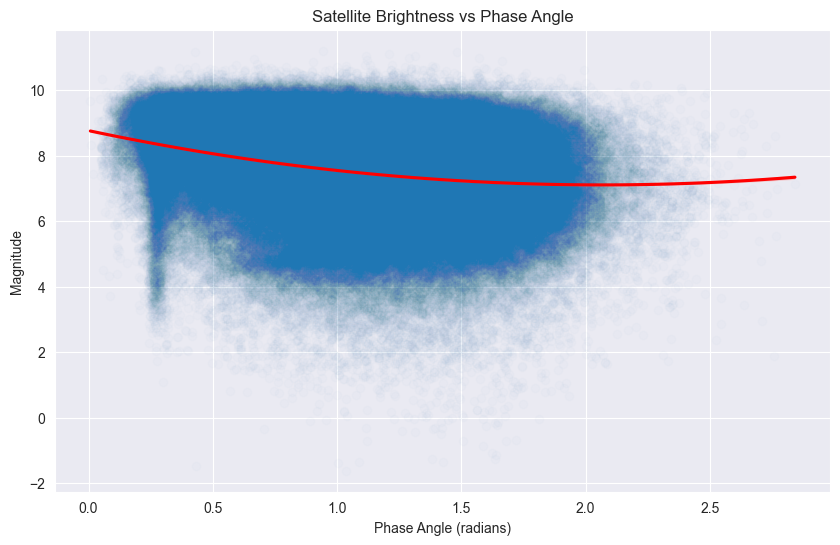

Correlation coefficient: shape: (2, 2)
┌─────────────────┬───────────┐
│ phase_angle_rad ┆ Mag       │
│ ---             ┆ ---       │
│ f64             ┆ f64       │
╞═════════════════╪═══════════╡
│ 1.0             ┆ -0.238693 │
│ -0.238693       ┆ 1.0       │
└─────────────────┴───────────┘
R-squared: 0.05697428619577281
P-value:  0.0


In [14]:
df_phase_angle = sampled_df[["phase_angle_rad", "Mag"]]

plt.figure(figsize=(10, 6))
sns.regplot(data=df_phase_angle, x="phase_angle_rad", y="Mag", order=2, scatter_kws={'alpha':0.01}, line_kws=dict(color='red'))
plt.title("Satellite Brightness vs Phase Angle")
plt.xlabel("Phase Angle (radians)")
plt.ylabel("Magnitude")
plt.show()

correlation = df_phase_angle.corr()
print(f"Correlation coefficient: {correlation}")

slope, intercept, r_value, p_value, std_err = stats.linregress(df_phase_angle["phase_angle_rad"], df_phase_angle["Mag"])
print(f"R-squared: {r_value**2}")
print("P-value: ", p_value)

### PCA analysis of Satlellite brightness
#### First I used the Shillouette method to determine the optimal number of clusters.

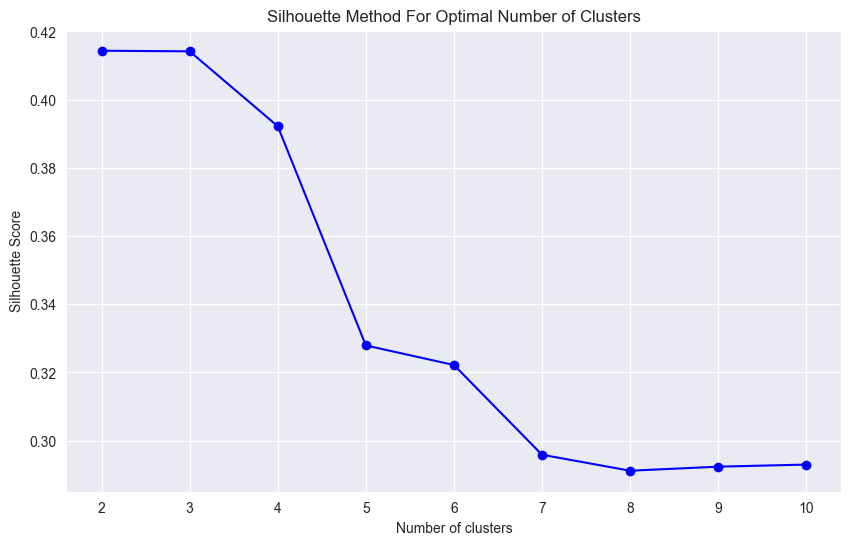

In [15]:
df = sampled_df[["Satellite", "Mag"]]

# Calculate the mean, standard deviation, max, and min of the brightness for each satellite
satellite_stats = df.to_pandas().pivot_table(index="Satellite", values="Mag", aggfunc=["mean", "std", "max", "min"]).reset_index()
satellite_stats.columns = ["Satellite", "mean_mag", "std_mag", "max_mag", "min_mag"]

satellite_stats = satellite_stats.fillna(satellite_stats.mean())

scaler = StandardScaler()
scaled_features = scaler.fit_transform(satellite_stats.drop(columns=["Satellite"]))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Silhouette method to determine the optimal number of clusters
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal Number of Clusters')
plt.show()

2 is the optimal number of clusters

#### K-means clustering

Explained variance by each component: [0.61818975 0.3109089 ]
Component loadings:
                        mean_mag   std_mag   max_mag   min_mag
Principal Component 1  0.617906 -0.236854  0.507024  0.552285
Principal Component 2  0.180814  0.791769  0.491670 -0.314115


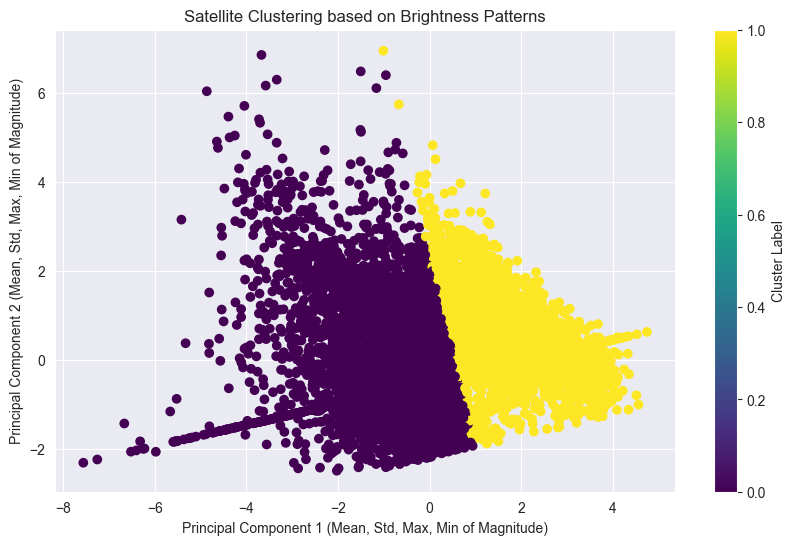

Cluster characteristics:
             Satellite  mean_mag   std_mag   max_mag   min_mag
Cluster                                                      
0        49801.693924  5.832711  0.772290  6.658017  4.881236
1        34407.569289  8.200075  0.713345  9.103452  6.913313
    Satellite  mean_mag   std_mag  max_mag  min_mag  Cluster
9          47  5.337368  1.055007  7.83881  3.31548        0
57        397  7.154894  1.020469  8.38086  3.30245        0
60        426  5.946088  1.149116  9.68594  3.72153        0
81        703  6.531895  1.000340  9.14068  4.83217        0
86        727  5.425391  1.108207  7.75277  2.77491        0


In [16]:
satellite_stats = df.to_pandas().pivot_table(index="Satellite", values="Mag", aggfunc=["mean", "std", "max", "min"]).reset_index()

satellite_stats.columns = ["Satellite", "mean_mag", "std_mag", "max_mag", "min_mag"]

satellite_stats = satellite_stats.fillna(satellite_stats.mean())

scaler = StandardScaler()
scaled_features = scaler.fit_transform(satellite_stats.drop(columns=["Satellite"]))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_
print("Explained variance by each component:", explained_variance)

loadings = pca.components_
feature_names = ["mean_mag", "std_mag", "max_mag", "min_mag"]
loading_matrix = pd.DataFrame(loadings, columns=feature_names, index=["Principal Component 1", "Principal Component 2"])
print("Component loadings:\n", loading_matrix)

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

satellite_stats["Cluster"] = cluster_labels

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap="viridis")
plt.title("Satellite Clustering based on Brightness Patterns")
plt.xlabel("Principal Component 1 (Mean, Std, Max, Min of Magnitude)")
plt.ylabel("Principal Component 2 (Mean, Std, Max, Min of Magnitude)")
plt.colorbar(scatter, label="Cluster Label")
plt.show()

# Analyzing cluster characteristics
cluster_analysis = satellite_stats.groupby("Cluster").mean()
print("Cluster characteristics:\n", cluster_analysis)

cluster_dfs = {}
for cluster in satellite_stats["Cluster"].unique():
    cluster_dfs[cluster] = satellite_stats[satellite_stats["Cluster"] == cluster]

cluster_0_df = cluster_dfs[0]
print(cluster_0_df.head())

##### Satellites can be divided among each others into 2 types according to their characteristics.
Though, this method does not seem to provide any substantial insights into the specific groups.
Prior knowledge of the data is required to make sense of the clusters.

### Variation in Brightness with respect to the Channel and Track of the Satellite

                            df         sum_sq     mean_sq           F  \
C(Channel)                 8.0    2196.392260  274.549033  277.682716   
C(Filter)                  4.0     901.549861  225.387465  227.960022   
C(Channel):C(Filter)      32.0      92.481923    2.890060    2.923047   
Residual              278592.0  275448.055221    0.988715         NaN   

                             PR(>F)  
C(Channel)             0.000000e+00  
C(Filter)             9.510326e-196  
C(Channel):C(Filter)   6.096462e-08  
Residual                        NaN  


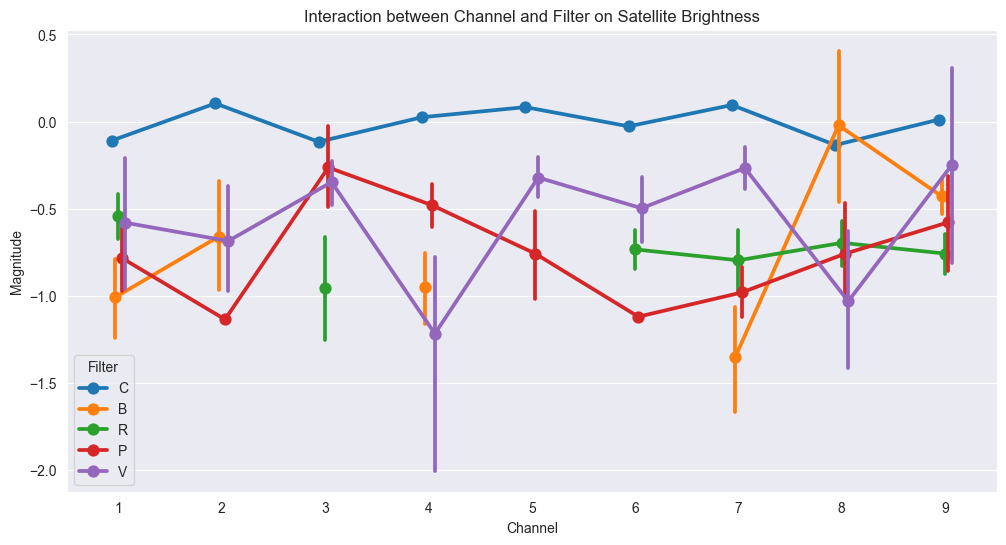

In [17]:
sampled_df = sampled_df_w_epoch.with_columns([
    pl.col("Epoch").dt.hour().alias("hour"),
    pl.col("Epoch").dt.month().alias("month")
])

# statsmodels work better with Pandas Dataframes hence I am converting them here
df = sampled_df.to_pandas()

# ANOVA models require the data to be normally distributed and have equal variances 
scaler = StandardScaler()
df[['Mag']] = scaler.fit_transform(df[['Mag']])

model = ols('Mag ~ C(Channel) + C(Filter) + C(Channel):C(Filter)', data=df).fit()
anova_results = anova_lm(model)

print(anova_results)

unique_filters = df['Filter'].unique()
plt.figure(figsize=(12, 6))
sns.pointplot(data=df, x='Channel', y='Mag', hue='Filter', dodge=True)
plt.title('Interaction between Channel and Filter on Satellite Brightness')
plt.xlabel('Channel')
plt.ylabel('Magnitude')
plt.show()

Satellite brightness is influenced by the satellite itself, the channel and the filter used to observe the satellite do not make much of a difference, the satellite brightness changes due its distance.

### Number of Satellites throughout the years, mean brightness through the years


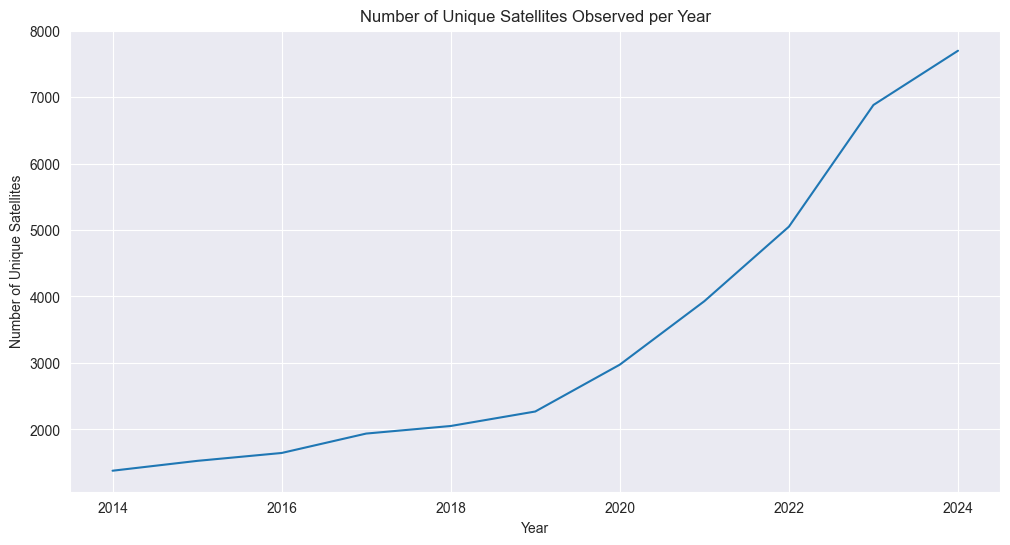

Slope: 619.4272727272727
P-value: 5.5039291704699525e-05


In [18]:
years_sampled_df = sampled_df.with_columns(pl.col("Epoch").dt.year().alias("year"))

satellites_per_year = years_sampled_df.group_by("year").agg(pl.col("Satellite").n_unique().alias("unique_satellites")).to_pandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=satellites_per_year, x="year", y="unique_satellites")
plt.title("Number of Unique Satellites Observed per Year")
plt.xlabel("Year")
plt.ylabel("Number of Unique Satellites")
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(satellites_per_year["year"], satellites_per_year["unique_satellites"])
print(f"Slope: {slope}")
print(f"P-value: {p_value}")

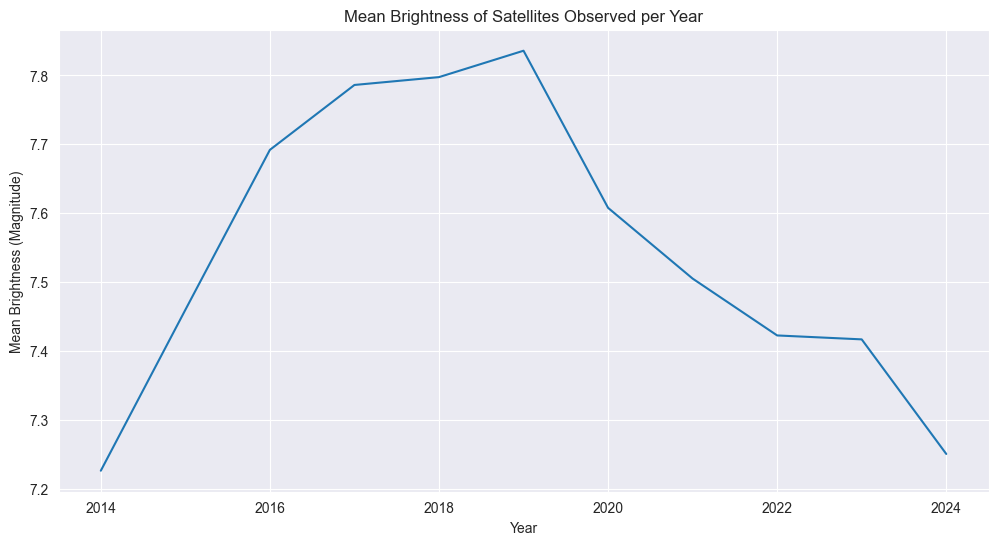

In [19]:
brightness_per_year = years_sampled_df.group_by("year").agg(pl.col("Mag").mean().alias("mean_brightness")).to_pandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=brightness_per_year, x="year", y="mean_brightness")
plt.title("Mean Brightness of Satellites Observed per Year")
plt.xlabel("Year")
plt.ylabel("Mean Brightness (Magnitude)")
plt.show()

### Correlation with Azimuth Ranges

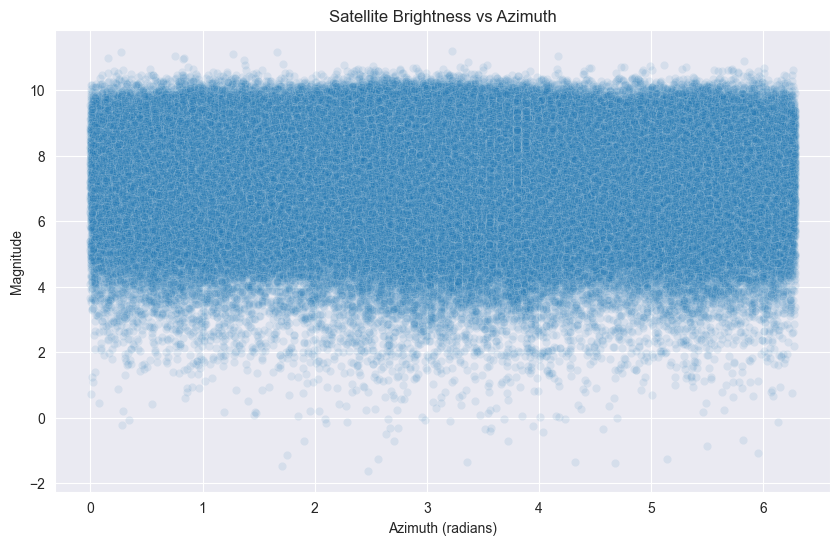

Correlation coefficient: shape: (2, 2)
┌───────────┬───────────┐
│ az_rad    ┆ Mag       │
│ ---       ┆ ---       │
│ f64       ┆ f64       │
╞═══════════╪═══════════╡
│ 1.0       ┆ -0.021081 │
│ -0.021081 ┆ 1.0       │
└───────────┴───────────┘
R-squared: 0.0004443996746596114
P-value: 9.080083731874113e-29


In [20]:
df_azimuth = sampled_df[["az_rad", "Mag"]]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_azimuth.to_pandas(), x="az_rad", y="Mag", alpha=0.1)
plt.title("Satellite Brightness vs Azimuth")
plt.xlabel("Azimuth (radians)")
plt.ylabel("Magnitude")
plt.show()

correlation = df_azimuth.corr()
print(f"Correlation coefficient: {correlation}")

slope, intercept, r_value, p_value, std_err = stats.linregress(df_azimuth["az_rad"], df_azimuth["Mag"])
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")

### Observations
The brightness of the satellite does not seem to be affected by the azimuth angle.
The p value is very high which means that the azimuth angle does not have a significant effect on the brightness of the satellite.

